### Training Script for Gyroscope Dataset using Feature Engineering and Hybrid CNN-LSTM Architecture 

@ Author : Niloy Chakraborty

@ Author Contact: chakrabortyniloy2018@gmail.com

In [ ]:
# Connect to Google Colab.  If using Jupyter, then comment this part
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/THESIS/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/THESIS


#### Load the Libraries

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
# import tensorflow_addons as tfa
from scipy import stats
from scipy.signal import find_peaks


In [ ]:
import os
import yaml

import tensorflow as tf

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM, Dropout,Dense,RepeatVector,TimeDistributed,Input,BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam as adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import load_model

#### Load the Training Data and Explore

In [ ]:
Category = "Gyr_FeatureEngg_CNN_LSTM_5_Class"

In [ ]:
# Change data path here
filepath = 'Gyr_25_secs_final_combined_faulty_data_train.csv'

In [ ]:
header = ['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','Altitude','Cmd1','Cmd2','Cmd3','Cmd4','Roll','Pitch','Yaw','ThurstRefOut1','ThurstRefOut2','ThurstRefOut3','ThurstRefOut4','Label']

In [ ]:
df = pd.read_csv(filepath, header = None)
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.iloc[:, 1:]
df["Label"] = pd.to_numeric(df["Label"])
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Altitude,Cmd1,Cmd2,Cmd3,Cmd4,Roll,Pitch,Yaw,ThurstRefOut1,ThurstRefOut2,ThurstRefOut3,ThurstRefOut4,Label
1,0.03380774,-0.11192460000000001,-9.492839,-0.0098925,-0.007933972,0.00108462,0.44,342.9332,-342.9577,342.8969,-342.9631,-1.965233e-06,-2.155978e-06,-5.859605e-07,-0.22403289999999998,-0.2240489,-0.22400920000000002,-0.22405239999999998,0
2,-0.116923,-0.2512355,-14.08014,-0.01084344,-0.009036063,-2.253169e-05,0.44,343.0175,-342.912,342.8928,-342.9287,-4.02452e-06,-4.6669999999999995e-06,-7.215308e-08,-0.224088,-0.224019,-0.2240065,-0.22403,0
3,0.22785189999999997,0.06732436,-13.62979,-0.008328836,-0.006301623,0.0025199379999999998,0.44,342.9608,-342.8717,343.0659,-342.8525,6.818334e-06,7.100436999999999e-06,5.960543e-07,-0.2240509,-0.2239928,-0.2241196,-0.22398020000000002,0
4,-0.01241245,-0.1545401,-13.94356,-0.01056849,-0.008493732,0.0007364108,0.44,342.8445,-343.066,342.7531,-343.0873,-3.975494e-06,-3.691068e-06,1.940148e-06,-0.223975,-0.2241197,-0.22391529999999998,-0.22413360000000002,0
5,0.21535289999999999,0.05578018,-13.64611,-0.008419157,-0.006429253,0.00240215,0.44,343.4182,-342.416,343.5187,-342.3979,1.696333e-05,1.88649e-05,1.3310810000000002e-05,-0.22434980000000002,-0.2236951,-0.2244154,-0.2236833,0


In [ ]:
df.columns

Index(['AccX', 'AccY', 'AccZ', 'GyrX', 'GyrY', 'GyrZ', 'Altitude', 'Cmd1',
       'Cmd2', 'Cmd3', 'Cmd4', 'Roll', 'Pitch', 'Yaw', 'ThurstRefOut1',
       'ThurstRefOut2', 'ThurstRefOut3', 'ThurstRefOut4', 'Label'],
      dtype='object')

In [ ]:
df.shape

(3075000, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075000 entries, 1 to 3075000
Data columns (total 19 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   AccX           object
 1   AccY           object
 2   AccZ           object
 3   GyrX           object
 4   GyrY           object
 5   GyrZ           object
 6   Altitude       object
 7   Cmd1           object
 8   Cmd2           object
 9   Cmd3           object
 10  Cmd4           object
 11  Roll           object
 12  Pitch          object
 13  Yaw            object
 14  ThurstRefOut1  object
 15  ThurstRefOut2  object
 16  ThurstRefOut3  object
 17  ThurstRefOut4  object
 18  Label          int64 
dtypes: int64(1), object(18)
memory usage: 469.2+ MB


In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

In [ ]:
# Change data type to numeric
df = df.apply(pd.to_numeric)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075000 entries, 1 to 3075000
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AccX           float64
 1   AccY           float64
 2   AccZ           float64
 3   GyrX           float64
 4   GyrY           float64
 5   GyrZ           float64
 6   Altitude       float64
 7   Cmd1           float64
 8   Cmd2           float64
 9   Cmd3           float64
 10  Cmd4           float64
 11  Roll           float64
 12  Pitch          float64
 13  Yaw            float64
 14  ThurstRefOut1  float64
 15  ThurstRefOut2  float64
 16  ThurstRefOut3  float64
 17  ThurstRefOut4  float64
 18  Label          int64  
dtypes: float64(18), int64(1)
memory usage: 469.2 MB


In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

### Data Pre-processing

### Feature Engineering

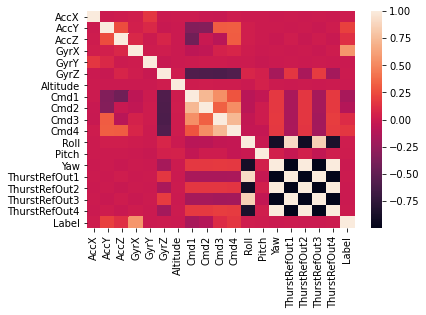

In [ ]:
import seaborn as sns

sns.heatmap(df.corr())
plt.show()

In [ ]:
new_cols = ["AccX","AccY","AccZ","GyrX","GyrY","GyrZ","Cmd4","Cmd3","Label"]

In [ ]:
df = df[new_cols]

In [ ]:
df.shape

(3075000, 9)

In [ ]:
df["Label"].value_counts()

0    1885107
3     306630
4     300858
1     297929
2     284476
Name: Label, dtype: int64

In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

#### Creating Sliding Windows and Perform Feature for every Windows 

In [ ]:
df_train = df

In [ ]:
x_list_acc = []
y_list_acc = []
z_list_acc = []
x_list_gyr = []
y_list_gyr = []
z_list_gyr = []
Cmd4 = []
Cmd3 = []
train_labels = []

window_size = 64
step_size = 40

# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    accx = df_train['AccX'].values[i: i + window_size]
    accy = df_train['AccY'].values[i: i + window_size]
    accz = df_train['AccY'].values[i: i + window_size]
    gyrx = df_train['GyrX'].values[i: i + window_size]
    gyry = df_train['GyrY'].values[i: i + window_size]
    gyrz = df_train['GyrZ'].values[i: i + window_size]
    Cmd31 = df_train['Cmd3'].values[i: i + window_size]
    Cmd41 = df_train['Cmd4'].values[i: i + window_size]

    label = stats.mode(df_train['Label'][i: i + window_size])[0][0]

    x_list_acc.append(accx)
    y_list_acc.append(accy)
    z_list_acc.append(accz)
    x_list_gyr.append(gyrx)
    y_list_gyr.append(gyry)
    z_list_gyr.append(gyrz)
    Cmd3.append(Cmd31)
    Cmd4.append(Cmd41)

    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean_acc'] = pd.Series(x_list_acc).apply(lambda x: x.mean())
X_train['y_mean_acc'] = pd.Series(y_list_acc).apply(lambda x: x.mean())
X_train['z_mean_acc'] = pd.Series(z_list_acc).apply(lambda x: x.mean())
X_train['x_mean_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.mean())
X_train['y_mean_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.mean())
X_train['z_mean_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.mean())
X_train['mean_Cmd3'] = pd.Series(Cmd3).apply(lambda x: x.mean())
X_train['mean_Cmd4'] = pd.Series(Cmd4).apply(lambda x: x.mean())


# std dev
X_train['x_std_acc'] = pd.Series(x_list_acc).apply(lambda x: x.std())
X_train['y_std_acc'] = pd.Series(y_list_acc).apply(lambda x: x.std())
X_train['z_std_acc'] = pd.Series(z_list_acc).apply(lambda x: x.std())
X_train['x_std_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.std())
X_train['std_Cmd3'] = pd.Series(Cmd3).apply(lambda x: x.std())
X_train['std_Cmd4'] = pd.Series(Cmd4).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad_acc'] = pd.Series(x_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_acc'] = pd.Series(y_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_acc'] = pd.Series(z_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['x_aad_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['aad_Cmd3'] = pd.Series(Cmd3).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['aad_Cmd4'] = pd.Series(Cmd4).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min_acc'] = pd.Series(x_list_acc).apply(lambda x: x.min())
X_train['y_min_acc'] = pd.Series(y_list_acc).apply(lambda x: x.min())
X_train['z_min_acc'] = pd.Series(z_list_acc).apply(lambda x: x.min())
X_train['x_min_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.min())
X_train['y_min_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.min())
X_train['z_min_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.min())
X_train['min_Cmd3'] = pd.Series(Cmd3).apply(lambda x: x.min())
X_train['min_Cmd4'] = pd.Series(Cmd4).apply(lambda x: x.min())


# max
X_train['x_max_acc'] = pd.Series(x_list_acc).apply(lambda x: x.max())
X_train['y_max_acc'] = pd.Series(y_list_acc).apply(lambda x: x.max())
X_train['z_max_acc'] = pd.Series(z_list_acc).apply(lambda x: x.max())
X_train['x_max_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.max())
X_train['y_max_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.max())
X_train['z_max_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.max())
X_train['max_Cmd3'] = pd.Series(Cmd3).apply(lambda x: x.max())
X_train['max_Cmd4'] = pd.Series(Cmd4).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff_acc'] = X_train['x_max_acc'] - X_train['x_min_acc']
X_train['y_maxmin_diff_acc'] = X_train['y_max_acc'] - X_train['y_min_acc']
X_train['z_maxmin_diff_acc'] = X_train['z_max_acc'] - X_train['z_min_acc']
X_train['x_maxmin_diff_gyr'] = X_train['x_max_gyr'] - X_train['x_min_gyr']
X_train['y_maxmin_diff_gyr'] = X_train['y_max_gyr'] - X_train['y_min_gyr']
X_train['z_maxmin_diff_gyr'] = X_train['z_max_gyr'] - X_train['z_min_gyr']
X_train['maxmin_diff_Cmd3'] = X_train['max_Cmd3'] - X_train['min_Cmd3']
X_train['maxmin_diff_Cmd4'] = X_train['max_Cmd4'] - X_train['max_Cmd4']

# median
X_train['x_median_acc'] = pd.Series(x_list_acc).apply(lambda x: np.median(x))
X_train['y_median_acc'] = pd.Series(y_list_acc).apply(lambda x: np.median(x))
X_train['z_median_acc'] = pd.Series(z_list_acc).apply(lambda x: np.median(x))
X_train['x_median_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.median(x))
X_train['y_median_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.median(x))
X_train['z_median_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.median(x))
X_train['median_Cmd3'] = pd.Series(Cmd3).apply(lambda x: np.median(x))
X_train['median_Cmd3'] = pd.Series(Cmd4).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad_acc'] = pd.Series(x_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_acc'] = pd.Series(y_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_acc'] = pd.Series(z_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))

X_train['x_mad_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['mad_Cmd3'] = pd.Series(Cmd3).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['mad_Cmd4'] = pd.Series(Cmd4).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR_acc'] = pd.Series(x_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_acc'] = pd.Series(y_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_acc'] = pd.Series(z_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

X_train['x_IQR_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['IQR_Cmd3'] = pd.Series(Cmd3).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['IQR_Cmd4'] = pd.Series(Cmd4).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x < 0))

X_train['x_neg_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x < 0))
X_train['neg_count_Cmd3'] = pd.Series(Cmd4).apply(lambda x: np.sum(x < 0))
X_train['neg_count_Cmd4'] = pd.Series(Cmd4).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x > 0))

X_train['x_pos_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x > 0))
X_train['pos_count_Cmd3'] = pd.Series(Cmd3).apply(lambda x: np.sum(x > 0))
X_train['pos_count_Cmd4'] = pd.Series(Cmd4).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x > x.mean()))

X_train['x_above_mean_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x > x.mean()))
X_train['above_mean_Cmd3'] = pd.Series(Cmd3).apply(lambda x: np.sum(x > x.mean()))
X_train['above_mean_Cmd4'] = pd.Series(Cmd4).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count_acc'] = pd.Series(x_list_acc).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_acc'] = pd.Series(y_list_acc).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_acc'] = pd.Series(z_list_acc).apply(lambda x: len(find_peaks(x)[0]))

X_train['x_peak_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: len(find_peaks(x)[0]))
X_train['peak_count_Cmd3'] = pd.Series(Cmd3).apply(lambda x: len(find_peaks(x)[0]))
X_train['peak_count_Cmd4'] = pd.Series(Cmd4).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness_acc'] = pd.Series(x_list_acc).apply(lambda x: stats.skew(x))
X_train['y_skewness_acc'] = pd.Series(y_list_acc).apply(lambda x: stats.skew(x))
X_train['z_skewness_acc'] = pd.Series(z_list_acc).apply(lambda x: stats.skew(x))

X_train['x_skewness_gyr'] = pd.Series(x_list_gyr).apply(lambda x: stats.skew(x))
X_train['y_skewness_gyr'] = pd.Series(y_list_gyr).apply(lambda x: stats.skew(x))
X_train['z_skewness_gyr'] = pd.Series(z_list_gyr).apply(lambda x: stats.skew(x))
X_train['skewness_Cmd3'] = pd.Series(Cmd3).apply(lambda x: stats.skew(x))
X_train['skewness_Cmd4'] = pd.Series(Cmd4).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis_acc'] = pd.Series(x_list_acc).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_acc'] = pd.Series(y_list_acc).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_acc'] = pd.Series(z_list_acc).apply(lambda x: stats.kurtosis(x))

X_train['x_kurtosis_gyr'] = pd.Series(x_list_gyr).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_gyr'] = pd.Series(y_list_gyr).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_gyr'] = pd.Series(z_list_gyr).apply(lambda x: stats.kurtosis(x))
X_train['kurtosis_Cmd3'] = pd.Series(Cmd3).apply(lambda x: stats.kurtosis(x))
X_train['kurtosis_Cmd4'] = pd.Series(Cmd4).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x**2/100))

X_train['x_energy_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x**2/100))
X_train['energy_Cmd3'] = pd.Series(Cmd3).apply(lambda x: np.sum(x**2/100))
X_train['energy_Cmd4'] = pd.Series(Cmd4).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train['avg_result_acc'] = [i.mean() for i in ((pd.Series(x_list_acc)**2 + pd.Series(y_list_acc)**2 + pd.Series(z_list_acc)**2)**0.5)]
X_train['avg_result_gyr'] = [i.mean() for i in ((pd.Series(x_list_gyr)**2 + pd.Series(y_list_gyr)**2 + pd.Series(z_list_gyr)**2)**0.5)]



# signal magnitude area
X_train['sma_acc'] =    pd.Series(x_list_acc).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list_acc).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list_acc).apply(lambda x: np.sum(abs(x)/100))

X_train['sma_gyr'] =    pd.Series(x_list_gyr).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list_gyr).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list_gyr).apply(lambda x: np.sum(abs(x)/100))


y_train = np.array(train_labels)


#### Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)


In [ ]:
X_train.shape

(76874, 129)

In [ ]:
n_features = X_train.shape[1]
TIME_STEPS= 64

In [ ]:
# Reshape data to feed into the Network
X_train = X_train.reshape(X_train.shape[0],1,n_features)

In [ ]:
print(X_train.shape, y_train.shape)


(76874, 1, 129) (76874,)


In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 47410]
 [    1  7363]
 [    2  7045]
 [    3  7603]
 [    4  7453]]


In [ ]:
y_train= y_train.reshape(-1, 1)

#### Label Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
# y_test = enc.transform(y_test)

In [ ]:
print(X_train.shape, y_train.shape)


(76874, 1, 129) (76874, 5)


### Create the Hybrid CNN LSTM Architecture

In [ ]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
# model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(128,activation='tanh', return_sequences=False))
model.add(Dropout(0.4))

model.add(Dense(30, activation='relu'))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 1, 64)             8320      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1, 32)             2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 32)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 30)               


### Train the Model

In [ ]:
# Function to Plot Training Accuracy and Loss
def plot_training(history):
    print(history.history.keys())

    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Epoch 1/200
3700/3700 [==============================] - 22s 5ms/step - loss: 0.8521 - accuracy: 0.6513 - val_loss: 1.5368 - val_accuracy: 0.5014
Epoch 2/200
3700/3700 [==============================] - 19s 5ms/step - loss: 0.5428 - accuracy: 0.7759 - val_loss: 0.8807 - val_accuracy: 0.5456
Epoch 3/200
3700/3700 [==============================] - 19s 5ms/step - loss: 0.4510 - accuracy: 0.8186 - val_loss: 0.5876 - val_accuracy: 0.7983
Epoch 4/200
3700/3700 [==============================] - 19s 5ms/step - loss: 0.4023 - accuracy: 0.8386 - val_loss: 0.3808 - val_accuracy: 0.8621
Epoch 5/200
3700/3700 [==============================] - 19s 5ms/step - loss: 0.3631 - accuracy: 0.8517 - val_loss: 0.2951 - val_accuracy: 0.8978
Epoch 6/200
3700/3700 [==============================] - 19s 5ms/step - loss: 0.3405 - accuracy: 0.8623 - val_loss: 0.2812 - val_accuracy: 0.9009
Epoch 7/200
3700/3700 [==============================] - 19s 5ms/step - loss: 0.3194 - accuracy: 0.8694 - val_loss: 0.2243 -

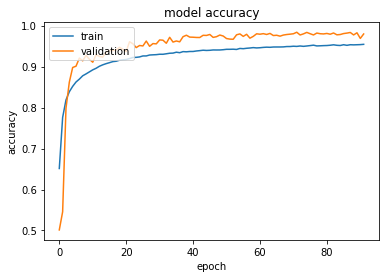

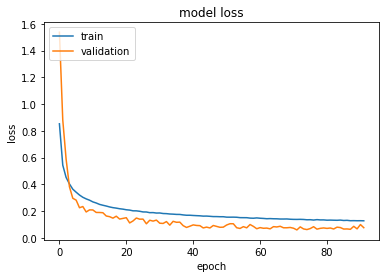

In [ ]:
def training(model, X_train, y_train):
    # Another control put in place to handle overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1,patience=20,mode='min',restore_best_weights=True)

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    # opt = tfa.optimizers.SWA(tf.keras.optimizers.SGD(), 100, 10)
    
    # compile the model and Train
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy']) 

    history = model.fit(X_train, y_train,epochs=200,batch_size=16,validation_split=0.23,shuffle=True,callbacks=[early_stopping])
    print(history.history.keys())
    # plot training performance over the epochs
    plot_training(history)
    return history

history= training(model, X_train, y_train)

### Save the Model

In [ ]:
import datetime
model.save("Gyr_Models/"+Category+"_"+str(TIME_STEPS)+"_"+f'{datetime.datetime.today().strftime("%d-%m-%Y:%H")}.h5')